In [1]:
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import plotly.express as px

tf.random.set_seed(1234)

In [2]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

In [3]:
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0226.off"))
mesh.show()

/home/airbagy/env/sta3431_env/lib/python3.8/site-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


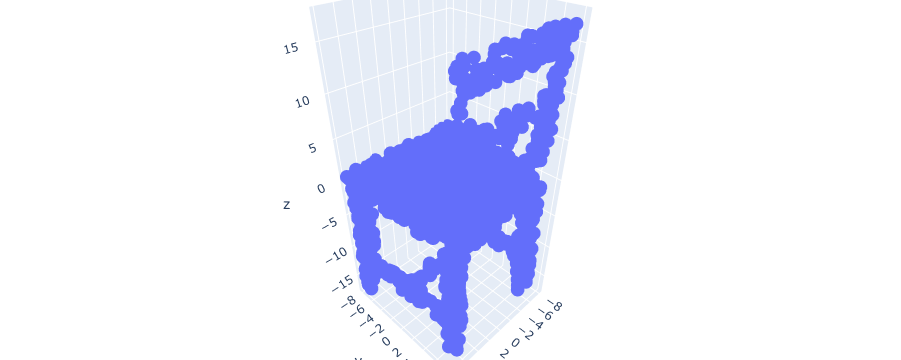

In [4]:
points = mesh.sample(2048)
points_t = list(map(list, zip(*points)))
fig = px.scatter_3d(x=points_t[0], y=points_t[1], z=points_t[2])
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [5]:
def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [6]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)

processing class: night_stand
processing class: toilet
processing class: monitor
processing class: sofa
processing class: table
processing class: dresser
processing class: bathtub
processing class: desk
processing class: bed
processing class: chair


In [7]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

2022-03-18 15:11:23.062647: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-18 15:11:23.065679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-18 15:11:23.065968: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-18 15:11:23.066932: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [72]:
tf.data.experimental.save(train_dataset, "data/ModelNet10/train_data")
tf.data.experimental.save(test_dataset, "data/ModelNet10/test_data")

In [70]:
test_dataset = tf.data.experimental.load('data/ModelNet10/test_data')
train_dataset = tf.data.experimental.load('data/ModelNet10/train_data')

In [3]:
def get_class_map(num_points=2048):
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("importing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files

    return class_map
DATA_DIR = "/home/airbagy/.keras/datasets/ModelNet10"
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32
CLASS_MAP = get_class_map(NUM_POINTS)

importing class: night_stand
importing class: toilet
importing class: monitor
importing class: sofa
importing class: table
importing class: dresser
importing class: bathtub
importing class: desk
importing class: bed
importing class: chair


In [9]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [10]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001, **kwargs):
        super(OrthogonalRegularizer, self).__init__(**kwargs)
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))
    
    def get_config(self):
        config = {"num_features":self.num_features,
                  "l2reg":self.l2reg}
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [11]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [13]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")

In [15]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=30, validation_data=test_dataset)

Epoch 1/30
125/125 [==============================] - 15s 100ms/step - loss: 3.0709 - sparse_categorical_accuracy: 0.3576 - val_loss: 28230190515623563362304.0000 - val_sparse_categorical_accuracy: 0.3998
Epoch 2/30
125/125 [==============================] - 12s 96ms/step - loss: 2.8628 - sparse_categorical_accuracy: 0.4458 - val_loss: 54972573124986404864.0000 - val_sparse_categorical_accuracy: 0.3590
Epoch 3/30
125/125 [==============================] - 12s 95ms/step - loss: 2.6481 - sparse_categorical_accuracy: 0.5021 - val_loss: 1676643357050273792.0000 - val_sparse_categorical_accuracy: 0.5286
Epoch 4/30
125/125 [==============================] - 12s 95ms/step - loss: 2.7082 - sparse_categorical_accuracy: 0.5267 - val_loss: 53373464098111488.0000 - val_sparse_categorical_accuracy: 0.4471
Epoch 5/30
125/125 [==============================] - 12s 95ms/step - loss: 2.4403 - sparse_categorical_accuracy: 0.5823 - val_loss: 2655341.0000 - val_sparse_categorical_accuracy: 0.4416
Epoch 6/

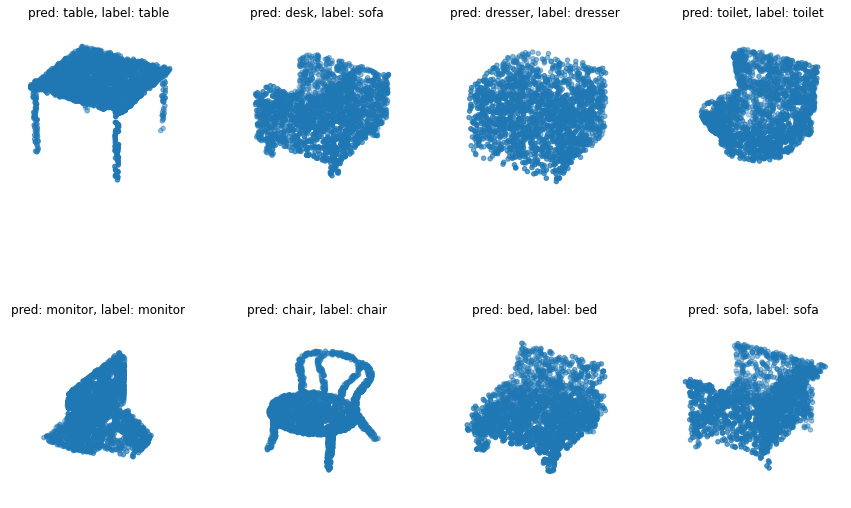

In [16]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()

In [17]:
# model.save('model/pointnet_modelnet10')

2022-03-18 15:30:49.419743: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model/pointnet_modelnet10/assets


In [74]:
model_load = keras.models.load_model('model/pointnet_modelnet10', 
                                     custom_objects={'OrthogonalRegularizer':OrthogonalRegularizer})

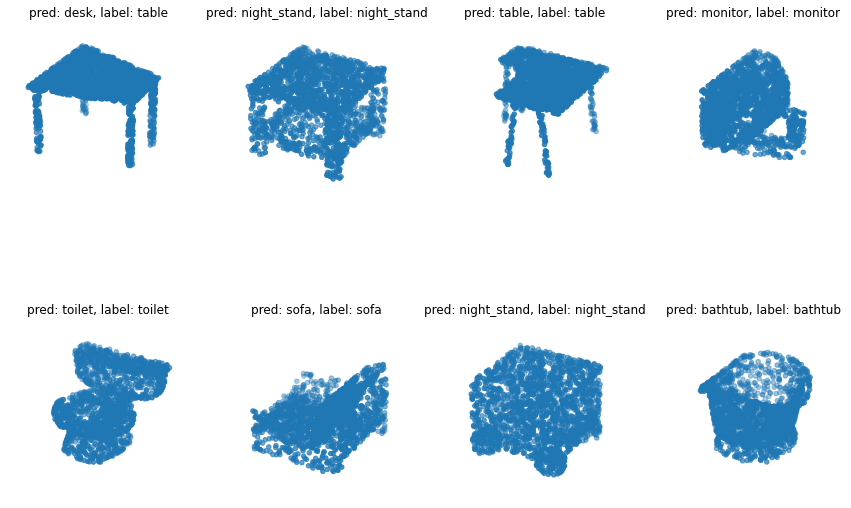

In [76]:
data = tf.data.experimental.load('data/ModelNet10/test_data').take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model_load.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()

In [39]:
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0226.off"))
mesh_points = mesh.sample(2048)

In [52]:
points.shape

(8, 2048, 3)

In [55]:
np.array([mesh_points]).shape

(1, 2048, 3)

In [57]:
pred = model_load.predict(np.array([mesh_points]))

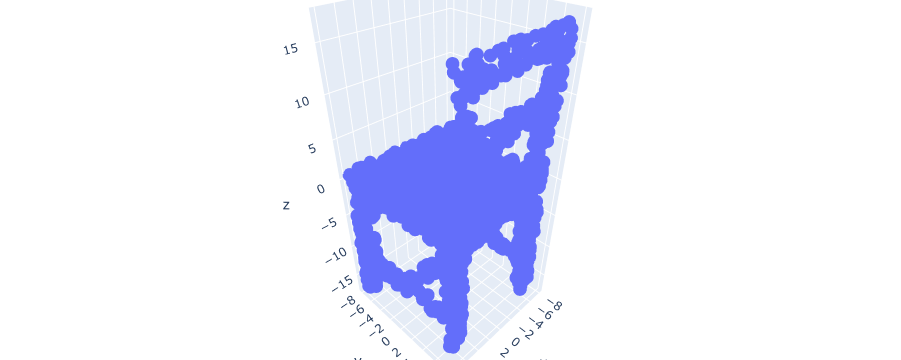

In [59]:
points_t = list(map(list, zip(*mesh_points)))
fig = px.scatter_3d(x=points_t[0], y=points_t[1], z=points_t[2])
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [64]:
tf.math.argmax(pred, -1).numpy()

array([9])

In [65]:
CLASS_MAP[9]

'chair'

In [69]:
CLASS_MAP

{0: 'night_stand',
 1: 'toilet',
 2: 'monitor',
 3: 'sofa',
 4: 'table',
 5: 'dresser',
 6: 'bathtub',
 7: 'desk',
 8: 'bed',
 9: 'chair'}